# Design of Experiment: персонализированная карусель курсов

Цель эксперимента — проверить, увеличивает ли персонализированная подборка курсов в карусели
«Вам понравится» пользовательскую вовлечённость и конверсию в запись на курсы по сравнению
со стандартной (неперсонализированной) каруселью.

## Гипотеза

Персонализированная карусель курсов приведёт к статистически значимому увеличению:

- конверсии в запись на курс после клика по карусели (CR_enroll),
- среднего чека (AOV),
- выручки на пользователя (ARPU)

по сравнению с контрольной группой.

## Метрики эксперимента

### Ключевая метрика
- **CR_enroll** = enroll / click_course  
  Конверсия в запись на курс после клика по карусели.

### Вспомогательные метрики
- **CTR** = click_course / view_carousel  
- **AOV** = revenue / number_of_pays  
- **ARPU** = revenue / number_of_users

Ключевым критерием успешности теста является статистически значимое увеличение CR_enroll
в тестовой группе относительно контрольной.


## Единица рандомизации и уровень агрегации

Единицей эксперимента является **пользователь (client_id)**.

Все метрики эксперимента рассчитываются на уровне пользователя (user-level), так как:
- рандомизация осуществляется по пользователям,
- пользователь получает либо персонализированную, либо стандартную карусель,
- повторные события одного пользователя не являются независимыми наблюдениями.

Агрегация на уровне user-day может использоваться исключительно для описательных целей
и визуализации динамики, но не для статистических выводов.


## Дизайн эксперимента

- Тип эксперимента: A/B-тест
- Группы:
  - A — стандартная (неперсонализированная) карусель
  - B — персонализированная карусель «Вам понравится»
- Разделение пользователей: 50% / 50%
- Доля трафика в эксперименте: не более 20% от общего
- Продолжительность теста: 7 дней
- Уровень значимости: α = 0.05
- Мощность теста: 80%


### Допущения

При проектировании A/B-теста были приняты следующие допущения:

- Пользователи случайным образом и равномерно распределяются между группами A и B.
- Поведение пользователей стационарно в течение эксперимента (7 дней).
- Между пользователями отсутствует влияние (no interference).
- Логирование событий (view, click, enroll, pay) является корректным и полным.
- Персонализация влияет на поведение пользователя, но не изменяет механики оплаты.


## Анализ исторических данных

Для оценки базовых значений метрик были использованы исторические данные до запуска эксперимента.

Ключевые ограничения данных:
- крайне низкая пользовательская активность,
- отсутствие покупок среди пользователей, просмотревших карусель,
- невозможность эмпирической оценки дисперсий для CR_enroll, AOV и ARPU.

В связи с этим расчёты ниже выполняются на основе допущений и/или прокси-метрик.


Baseline-оценки и ограничения данных основаны на результатах exploratory analysis (см. ноутбук `1_exploratory_analysis.ipynb`).

baseline используется исключительно для поведенческих метрик,
для revenue-метрик baseline не может быть оценён на этих данных.

## Минимальный детектируемый эффект (MDE)

Минимальный детектируемый эффект (MDE) — это наименьшее изменение метрики,
которое эксперимент способен обнаружить с заданной вероятностью (power = 80%)
при уровне значимости α = 0.05.

### Допущения

Ввиду отсутствия наблюдаемых конверсий среди пользователей карусели,
в качестве baseline-значения CR_enroll используется гипотетическое значение,
основанное на продуктовых бенчмарках EdTech.

Это допущение используется исключительно для иллюстрации зависимости MDE от размера выборки
и не интерпретируется как реальная оценка эффекта.

В рамках учебного проекта расчёты выполнены на исторических логах без фактического разбиения на группы. В реальном эксперименте расчёты будут повторены после запуска A/B-теста.

In [11]:
from scipy.stats import norm
import numpy as np

def get_MDE(mu, std, sample_size, alpha=0.05, power=0.8):
    """
    Рассчитывает минимальный обнаруживаемый эффект (MDE) для заданного базового среднего значения,
    стандартного отклонения и размера выборки для двухвыборочного t-теста.

    Аргументы:
        mu (float): Базовое среднее значение метрики.
        std (float): Стандартное отклонение метрики.
        sample_size (int): Количество наблюдений в каждой группе (контрольной и тестовой).
        alpha (float): Уровень значимости (вероятность ошибки I рода, по умолчанию 0.05).
        power (float): Статистическая мощность (1 - вероятность ошибки II рода, по умолчанию 0.8).

    Возвращает:
        tuple: (Абсолютный MDE, Относительный MDE)
    """
    # Z-оценка для альфа (двусторонний тест)
    z_alpha = norm.ppf(1 - alpha / 2)

    # Z-оценка для бета (односторонний тест для расчета мощности, так как MDE предназначен для обнаружения разницы в одном направлении)
    z_beta = norm.ppf(power)

    # Объединенное стандартное отклонение (предполагается равная дисперсия и размеры выборок)
    # Для простоты используется заданное стандартное отклонение для каждой группы
    pooled_std = std

    # Стандартная ошибка разности для двух групп с равным размером выборки
    se_diff = pooled_std * np.sqrt(2 / sample_size)

    # Абсолютный MDE
    mde_absolute = (z_alpha + z_beta) * se_diff

    # Относительный MDE
    mde_relative = mde_absolute / mu

    return mde_absolute, mde_relative

# Определение гипотетических базовых значений согласно контексту ноутбука
# Эти значения являются иллюстративными и основаны на продуктовых бенчмарках EdTech
# (из текстовой ячейки 'wI_xm-bmHwV8')
baseline_cr = 0.02 # Пример: 2% коэффициент конверсии
baseline_std = np.sqrt(baseline_cr * (1 - baseline_cr)) # Стандартное отклонение для биномиального распределения

print(f"Гипотетический базовый CR: {baseline_cr:.4f}")
print(f"Гипотетическое базовое стандартное отклонение: {baseline_std:.4f}")

Гипотетический базовый CR: 0.0200
Гипотетическое базовое стандартное отклонение: 0.1400


In [16]:
import numpy as np

# пример: зависимость MDE от размера выборки
sample_sizes = np.arange(200, 5000, 200)
mde_values = [
    get_MDE(mu=baseline_cr, std=baseline_std, sample_size=n)[1]
    for n in sample_sizes
]

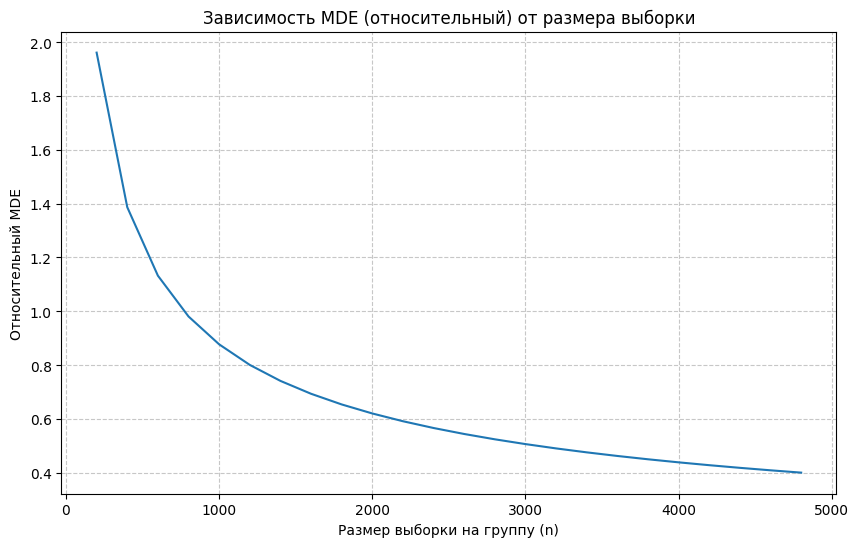

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x=sample_sizes, y=mde_values)
plt.title('Зависимость MDE (относительный) от размера выборки')
plt.xlabel('Размер выборки на группу (n)')
plt.ylabel('Относительный MDE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

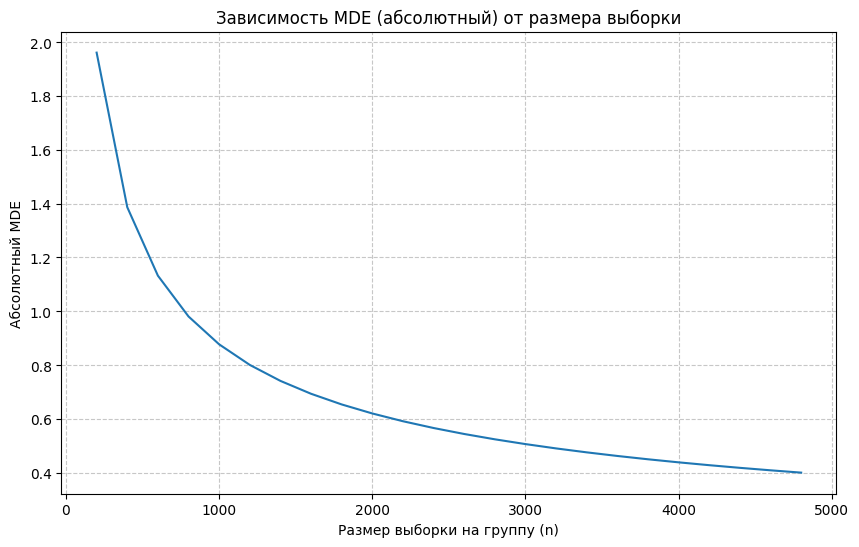

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x=sample_sizes, y=mde_values)
plt.title('Зависимость MDE (абсолютный) от размера выборки')
plt.xlabel('Размер выборки на группу (n)')
plt.ylabel('Абсолютный MDE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [15]:
from scipy.stats import norm
import numpy as np

def get_sample_size(mu, std, mde_absolute=None, mde_relative=None, alpha=0.05, power=0.8):
    """
    Рассчитывает необходимый размер выборки для заданного MDE, базового среднего значения
    и стандартного отклонения для двухвыборочного t-теста.

    Аргументы:
        mu (float): Базовое среднее значение метрики.
        std (float): Стандартное отклонение метрики.
        mde_absolute (float, optional): Желаемый абсолютный MDE.
        mde_relative (float, optional): Желаемый относительный MDE. Один из mde_absolute или mde_relative должен быть указан.
        alpha (float): Уровень значимости (вероятность ошибки I рода, по умолчанию 0.05).
        power (float): Статистическая мощность (1 - вероятность ошибки II рода, по умолчанию 0.8).

    Возвращает:
        int: Необходимый размер выборки на группу.
    """
    if mde_absolute is None and mde_relative is None:
        raise ValueError("Необходимо указать либо mde_absolute, либо mde_relative.")

    if mde_relative is not None:
        mde_absolute = mu * mde_relative

    if mde_absolute is None:
        raise ValueError("MDE (абсолютный) не может быть None после расчета из относительного MDE.")

    # Z-оценка для альфа (двусторонний тест)
    z_alpha = norm.ppf(1 - alpha / 2)

    # Z-оценка для бета (односторонний тест для расчета мощности)
    z_beta = norm.ppf(power)

    # Объединенное стандартное отклонение (предполагается равная дисперсия)
    pooled_std = std

    # Решение для sample_size из формулы MDE:
    # MDE = (z_alpha + z_beta) * pooled_std * sqrt(2 / sample_size)
    # MDE / ((z_alpha + z_beta) * pooled_std) = sqrt(2 / sample_size)
    # (MDE / ((z_alpha + z_beta) * pooled_std))^2 = 2 / sample_size
    # sample_size = 2 / ((MDE / ((z_alpha + z_beta) * pooled_std))^2)
    # sample_size = 2 * (( (z_alpha + z_beta) * pooled_std) / MDE)^2

    numerator = (z_alpha + z_beta) * pooled_std
    sample_size = 2 * (numerator / mde_absolute)**2

    return int(np.ceil(sample_size)) # Округляем вверх до целого числа

# Пример использования
# Используем те же гипотетические значения, что и раньше
baseline_cr = 0.02
baseline_std = np.sqrt(baseline_cr * (1 - baseline_cr))

# Желаемый относительный MDE, например, увеличение на 10% от baseline_cr
desired_relative_mde = 0.10
desired_absolute_mde = baseline_cr * desired_relative_mde

required_n = get_sample_size(
    mu=baseline_cr,
    std=baseline_std,
    mde_relative=desired_relative_mde
)

print(f"Базовый CR: {baseline_cr:.4f}")
print(f"Базовое стандартное отклонение: {baseline_std:.4f}")
print(f"Желаемый относительный MDE: {desired_relative_mde:.2%}")
print(f"Желаемый абсолютный MDE: {desired_absolute_mde:.4f}")
print(f"Необходимый размер выборки на группу: {required_n}")

# Пример с абсолютным MDE
desired_absolute_mde_example = 0.005 # Например, хотим обнаружить изменение CR на 0.5 процентных пунктов
required_n_abs = get_sample_size(
    mu=baseline_cr,
    std=baseline_std,
    mde_absolute=desired_absolute_mde_example
)
print(f"\nЖелаемый абсолютный MDE: {desired_absolute_mde_example:.4f}")
print(f"Необходимый размер выборки на группу (для абсолютного MDE): {required_n_abs}")

Базовый CR: 0.0200
Базовое стандартное отклонение: 0.1400
Желаемый относительный MDE: 10.00%
Желаемый абсолютный MDE: 0.0020
Необходимый размер выборки на группу: 76920

Желаемый абсолютный MDE: 0.0050
Необходимый размер выборки на группу (для абсолютного MDE): 12308


Функция get_sample_size успешно выполнена, и были рассчитаны необходимые размеры выборки для заданных MDE:

Для относительного MDE в 10% (что соответствует абсолютному MDE в 0.002) при базовом CR 0.0200, необходимый размер выборки на группу составляет 76920.

Для абсолютного MDE в 0.005 (что означает обнаружение изменения CR на 0.5 процентных пункта) при тех же базовых значениях, необходимый размер выборки на группу составляет 12308.

Это показывает, что для обнаружения меньшего относительного эффекта требуется значительно больший размер выборки.

Полученные значения MDE следует рассматривать как ориентировочные, так как baseline-оценка дисперсии основана на малом объёме данных и не содержит информации о покупках.

## Использование прокси-метрик

В условиях отсутствия достаточного числа покупок,
на раннем этапе эксперимента может быть использована прокси-метрика CTR.

CTR:
- имеет ненулевую дисперсию,
- напрямую отражает влияние персонализации,
- позволяет валидировать гипотезу до анализа downstream-метрик.

Рекомендуется рассматривать эксперимент как многошаговый:
сначала оценка эффекта на CTR, затем — на CR_enroll и выручку.

## Рекомендация: A/A-тест

Перед запуском A/B-теста рекомендуется провести A/A-тест для проверки:
- корректности рандомизации,
- стабильности логирования,
- отсутствия систематических различий между группами.

Отсутствие значимых различий в A/A-тесте является обязательным условием
для интерпретации результатов A/B-эксперимента.

## Итоговый вывод по дизайну эксперимента

В рамках данного проекта был спроектирован A/B-тест для оценки влияния персонализированной карусели курсов «Вам понравится» на поведение пользователей образовательной платформы.

В качестве ключевой метрики была выбрана конверсия в запись на курс после клика по карточке курса (CR_enroll), так как она напрямую отражает эффективность персонализации на этапе принятия решения. Дополнительно были рассмотрены вспомогательные метрики CTR, AOV и ARPU.

Анализ исторических логов показал, что данные по карусели характеризуются крайне низкой пользовательской активностью и отсутствием событий оплаты. В связи с этим baseline-оценки и расчёты дисперсий могут быть корректно выполнены только для поведенческих метрик (CTR и CR_enroll). Метрики, связанные с выручкой (AOV, ARPU), не могут быть использованы для количественной оценки эффекта персонализации на текущих данных и рассматриваются исключительно на уровне гипотезы.

Расчёт минимального детектируемого эффекта (MDE) выполнен с учётом принятых допущений, двухгруппового дизайна эксперимента, ограничения в 20% доступного трафика и целевой длительности эксперимента в 7 дней. Полученные значения MDE следует интерпретировать как ориентировочные, так как они основаны на ограниченном объёме исторических данных и не отражают вариативность покупок.

Таким образом, текущий этап проекта позволяет:
- обосновать выбор метрик и уровня агрегации для A/B-теста,
- сформировать корректный дизайн эксперимента,
- определить требования к объёму выборки и качеству данных для будущего запуска.

Для проведения полноценного A/B-тестирования и оценки влияния персонализации на выручку требуется реальный эксперимент с корректным логированием событий оплаты и достаточным объёмом наблюдений.
